
## Домашнее задание 6. Линейная регрессия.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

---
### Задача 1.

Скоро лето &mdash; идеальное время года для путешествий и прогулок на велосипедах. В крупных городах обычно развиты сети проката велосипедов, предоставляющие удобный сервис. Одной из важных задач таких компаний является прогнозирование количества арендованных велосипедов в зависимости от времени года и погодных условий.

Рассмотрим датасет <a target="_blank" href="https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset">Bike Sharing Dataset</a> от компании <a target="_blank" href="https://www.capitalbikeshare.com/">Capital Bikeshare</a>, располагающей автоматизированными пунктами проката велосипедов. В датасете по дням записаны календарная информация и погодные условия, а также число прокатов в этот день. Цель &mdash; предсказать количество арендованных велосипедов по остальным характеристикам.

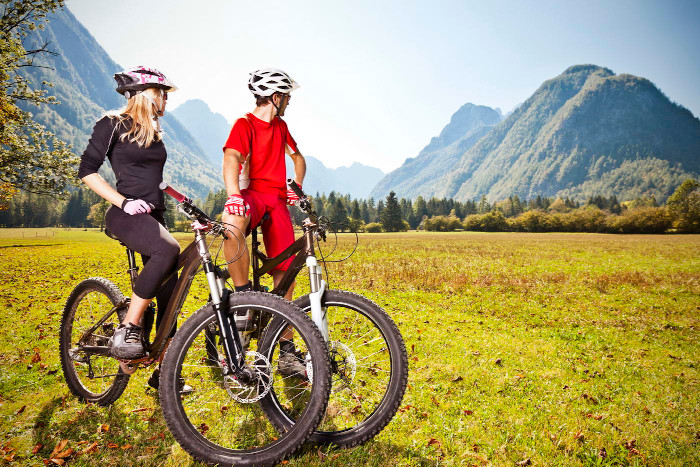

Будем работать только со следующими признаками:
* `season`: время года: 1 &mdash; зима, 2 &mdash; весна, 3 &mdash; лето, 4 &mdash; осень;
* `mnth`: месяц от 1 до 12;
* `holiday`: является ли текущий день праздничным;
* `weekday`: день недели от 0 до 6;
* `workingday`: является ли текущий день рабочим или выходным;
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман);
* `temp`: температура в Цельсиях;
* `atemp`: температура по ощущениям в Цельсиях;
* `hum`: влажность воздуха;
* `windspeed`: скорость ветра;
* `cnt`: количество арендованных велосипедов в текущий день.

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html">ноутбук</a> с занятия по линейной регрессии.

---

Скачайте данные, загрузите их с помощью `pandas` и разделите на обучающую и тестовую части в соотношении 4:1. Далее всю аналитику необходимо проводить только на обучающей части данных.

In [58]:
data = pd.read_csv('./day.csv', parse_dates=[0])

In [59]:
data = data.loc[:, ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
                'temp', 'atemp', 'hum', 'windspeed', 'cnt']]
data.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [60]:
train, test = train_test_split(data, test_size=0.2)
train.shape, test.shape

((584, 11), (147, 11))

#### 1. Визуальный анализ

Посмотрите по графикам, как *целевой признак зависит от остальных* и поймите характер этой зависимости. Старайтесь строит информативные графики.

Какие признаки категориальные, а какие &mdash; вещественные? Учтите это при построении информативных графиков.

Выделим категории признаков

In [61]:
categorial_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']  # категориальные признаки
real_features = ['temp', 'atemp', 'hum', 'windspeed']  # вещественные признаки
target_feature = 'cnt'

Категориальные: season, mnth, holiday, weekday, workingday, weathersit
Вещественные: temp, atemp, hum, windspeed

Сначала найдем зависимость целевого признака от вещественных признаков

In [62]:
sns.set(style='darkgrid', font_scale=1.3, palette='Set2')

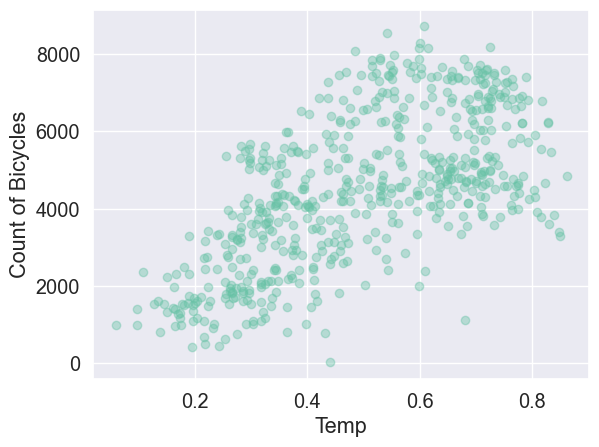

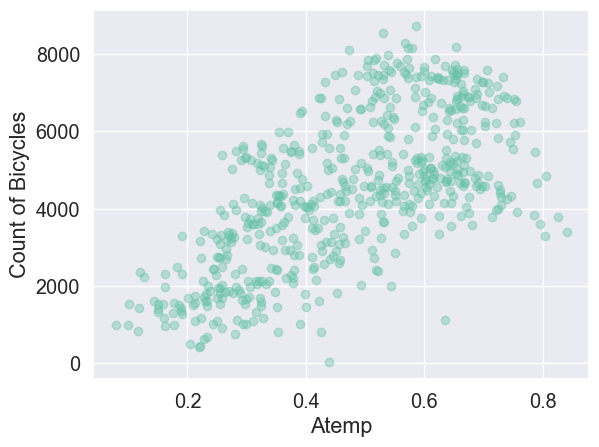

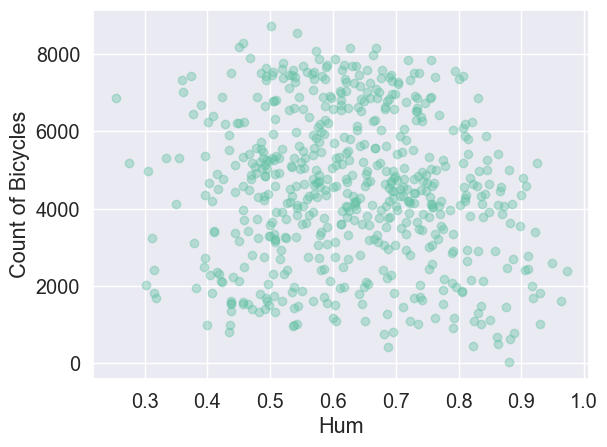

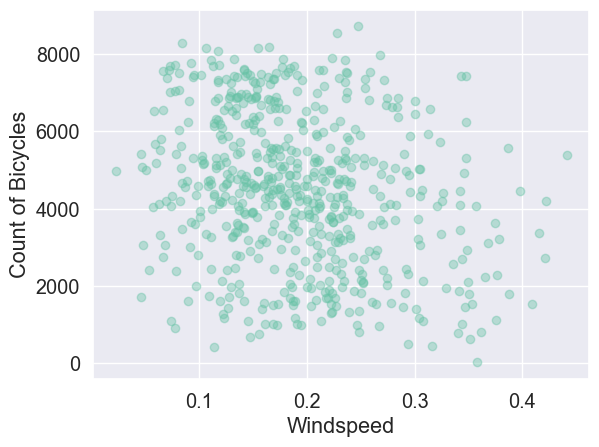

In [63]:
for col in train.loc[:, real_features]:
    plt.scatter(train[col], train['cnt'], alpha = 0.4)
    plt.xlabel(col.capitalize())
    plt.ylabel('Count of Bicycles')
    plt.show()

Теперь посмотрим на зависимость от категориальных признаков

In [64]:
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

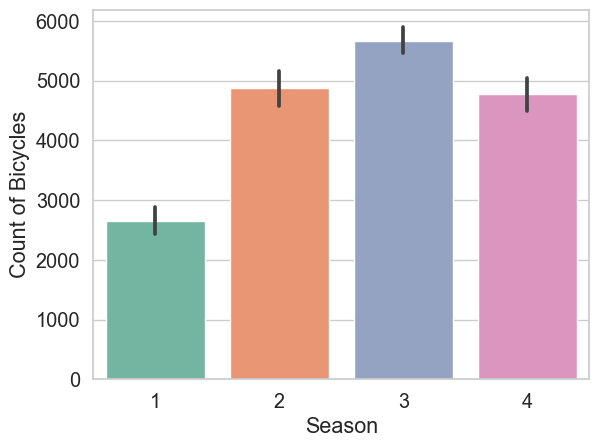

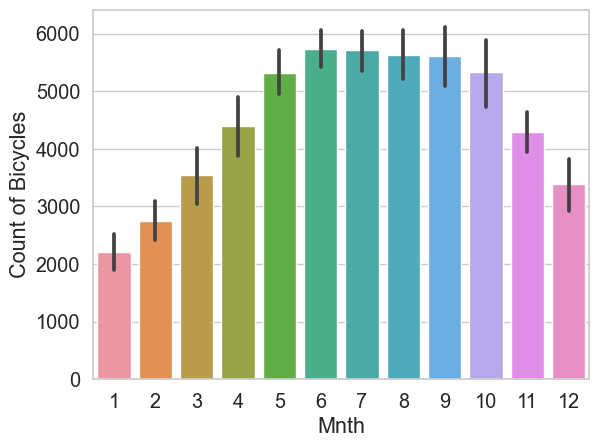

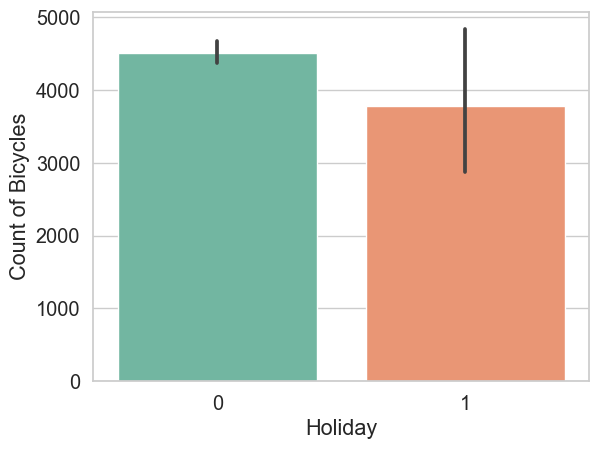

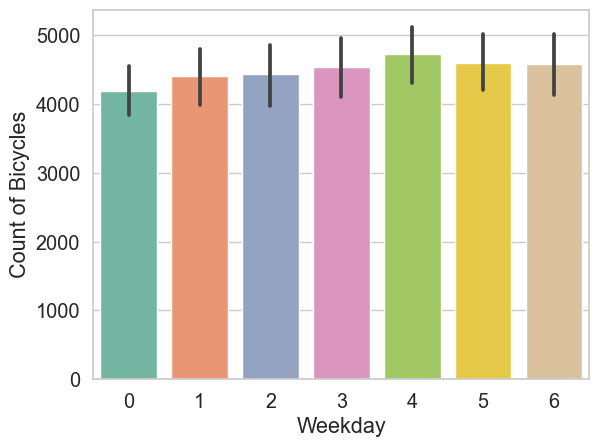

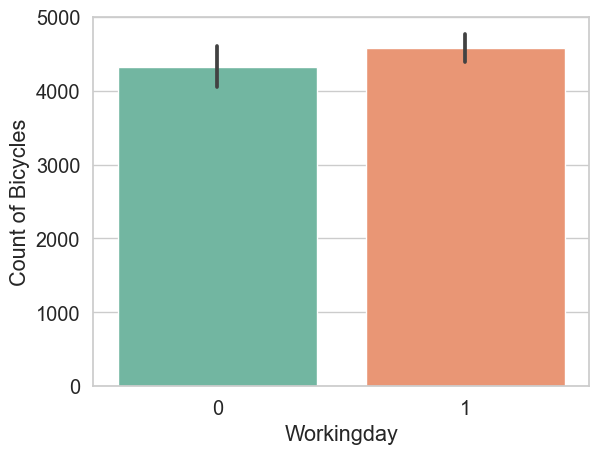

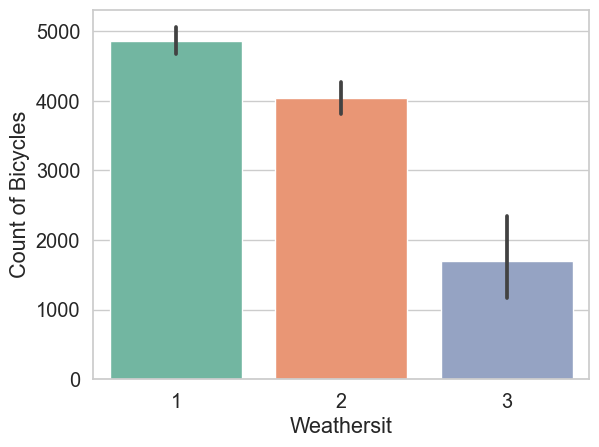

In [65]:
for col in train.loc[:, categorial_features]:
    sns.barplot(x = col, y = 'cnt', data = train)
    plt.ylabel('Count of Bicycles')
    plt.xlabel(col.capitalize())
    plt.show()

Сделайте выводы по графикам. В частности, ответьте на следующие вопросы.
* Есть ли в данных явные выбросы, то есть точки, далеко находящиеся от основной массы точек?
* Стоит ли рассматривать какие-либо нелинейные функции от признаков? Не стоит придумывать сложные функции, достаточно рассмотреть $x^2$, $\log x$ и $I\{x > c\}$.



**Выводы по графикам:**

Из графиков зависимости количества арендованных велосипедов от вещественных признаков можно сделать вывод, что число велосипедов, вероятно, имеет линейную зависимость от температуры и от температуры по ощущениям.

Анализ категориальных признаков показал, что количество арендованных велосипедов зависит от сезонности, а именно в период с мая по сентябрь достигается наибольшее значение. В выходные дни количество велосипедов немного превышает значение в будни, а число аренд в праздничные дни незначительно меньше, чем в обычные дни. Также погодные условия оказывают влияние на спрос аренды, при благоприятной погоде он увеличивается.

Есть выбросы слишком сильного ветра, для влажности выброс со значение примерно равным 0.

#### 2. Подготовка данных

Опишите по шагам процедуру предобработки данных, которая будет включать работу с выбросами, преобразования вещественных и категориальных признаков, возможно, что-то еще.

**Процедура предобработки данных:**

1. Удаление выбросов
2. Преобразуем категориальные признаки, а именно из одного категориального делаем несколько бинарных признаков

Реализуйте данную процедуру.

Проверим, есть ли среди значений пропущенные(null), и при необходимости заменим их.

In [66]:
train.isnull().sum()

season        0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Определим выбросы и заменим их на медиану значений для каждого вещественного признака

In [67]:
for col in train.loc[:, real_features]:
    a = train[col].quantile(0.25)
    b = train[col].quantile(0.75)
    diff = b - a
    low = a - 1.5 * diff
    high = b + 1.5 * diff
    train[col] = np.where(train[col] < low, np.nan, train[col])
    train[col] = np.where(train[col] > high, np.nan, train[col])
train.dropna(inplace = True)

Преобразуем категориальные признаки, а именно из одного категориального делаем несколько бинарных признаков по количеству различных значений исходного признака.

При построении кодировщика для наших данных учтем ряд особенностей:

1. указываем drop='first', то есть одну категорию нужно исключить;

2. указываем sparse=False, то есть вернуть нужно неразреженную матрицу;

3. нужно выполнить обучение, что в данном случае подразумевает построение и сохранение правила преобразования;

4. сразу же кодируем признаки из обучающего множества;

In [68]:
encoder = OneHotEncoder(drop='first', sparse=False)  # объявляем модель
train_bicycles = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_bicycles

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]])

Соединим вместе вещественные признаки и закодированные категориальные

In [69]:
X_train = np.hstack([train[real_features], train_bicycles])
X_train.shape

(576, 28)

#### 3. Обучение модели и ее анализ

Обучите линейную регрессию из `sklearn` на полученных данных и посмотрите на полученные оценки коэффициентов (в т.ч. свободный коэффициент).

Теперь обучим модель линейной регрессии по нашим данным. Указываем fit_intercept=True для оценки свободного коэффициента, что позволяет не добавлять в матрицу признаков столбец из единиц.

In [70]:
model = LinearRegression(fit_intercept=True)  # объявляем модель
model.fit(X_train, train[target_feature])  # обучаем

LinearRegression()

Посмотрим на результат обучения. Оценки коэффициентов перед признаками

In [71]:
model.coef_

array([ 5.64644484e+02,  6.73630363e+03, -3.34547507e+03, -3.44502130e+03,
        6.39271857e+02,  7.20695165e+02,  1.46199497e+03, -4.13499878e+01,
        1.34967463e+02,  1.42892480e+02,  3.18921636e+02, -3.56610885e+02,
       -8.26451836e+02, -3.61070885e+02,  3.37737893e+02,  2.91398875e+02,
       -2.53469652e+02, -1.57038548e+02, -7.00982512e+15,  7.00982512e+15,
        7.00982512e+15,  7.00982512e+15,  7.00982512e+15,  7.00982512e+15,
        4.09738565e+02, -7.00982512e+15, -1.79357277e+02, -1.68233295e+03])

Оценка свободного коэффициента

In [72]:
model.intercept_

2937.9548611111113

Посчитайте ошибку предсказания на тестовой выборке по метрикам RMSE, MAE, MAPE. Подробнее можно почитать в <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html#3.-Тестирование-и-оценка-качества">ноутбуке</a> с занятия.

*Замечание.* Если в тестовой части тоже есть "большие" выбросы, их стоит убрать. Наша модель не должна пытаться их предсказать, но в то же время выбросы вносят существенный вклад в значение метрики. 

In [73]:
# Кодируем категориальные признаки с помощью метода transform обученного ранее кодировщика
test_bicycles = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_bicycles])

In [74]:
test_bicycles

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

Выполним предсказание построенной ранее моделью с помощью метода predict

In [75]:
test_preds = model.predict(X_test)

Посчитаем RMSE (root MSE)

In [76]:
np.sqrt(((test[target_feature] - test_preds) ** 2).mean())

1368.8538953737836

Посчитаем метрику MAE (mean absolute error)

In [77]:
metrics.mean_absolute_error(test[target_feature], test_preds)

1159.2667407498043

Посчитаем метрику MAPE (mean absolute percentage error)

In [78]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()
mean_absolute_percentage_error(test[target_feature], test_preds)

34.678374911878976

Попробуйте посчитать оценку коэффициентов с помощью формулы, полученной на занятии. Не забудьте про константный признак. В чем заключается проблема?

*Подсказка.* Подумайте о зависимостях между признаками.

Формула: $(X^TX)^{-1}X^TY$

В данной формуле есть проблема, связанная с зависимостью между признаками. Если существует линейная зависимость между признаками, матрица $(X^TX)$ может быть вырожденной, тогда формула будет неверной.

In [79]:
x = train.loc[:, ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
                'temp', 'atemp', 'hum', 'windspeed']]
np.linalg.inv(x.T @ x) @ x.T @ np.array(train['cnt'])

0      560.320170
1      -33.395765
2      164.666684
3       90.935675
4      340.394629
5     -449.604700
6   -14448.320051
7    23266.624455
8     -869.618238
9      275.137383
dtype: float64

Исправьте эту проблему, посчитайте оценки коэффициентов, а также ошибку предсказания.

Исправим ошибку, убрав столбцы ощущаемая температура (atemp) и сезон (season).

In [80]:
X_train = train.loc[:, ['mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
                'temp','hum', 'windspeed']]
Y_train = train['cnt']
X_test = test.loc[:, ['mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
                'temp','hum', 'windspeed']]
Y_test = test['cnt']

In [81]:
categorial_features = ['mnth', 'holiday', 'weekday', 'workingday', 'weathersit']  # категориальные признаки
real_features = ['temp', 'hum', 'windspeed']  # вещественные признаки
target_feature = 'cnt'

In [82]:
encoder = OneHotEncoder(drop='first', sparse=False)  # объявляем модель
train_bicycles = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_bicycles

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [83]:
X_train = np.hstack([train[real_features], train_bicycles])
X_train.shape

(576, 24)

In [84]:
model = LinearRegression(fit_intercept=True)  # объявляем модель
model.fit(X_train, Y_train)  # обучаем
model.coef_

array([ 6750.70523485, -3224.96749869, -4129.14433617,   -14.16714243,
         315.91025897,   823.87028925,   908.85867933,   196.13405215,
        -230.36922331,   220.64655294,  1176.40583981,  1741.30798776,
        1229.39825201,   789.04614974,  -232.20006523,    29.96843196,
         -34.73488408,    34.5446213 ,   129.68791637,   -44.37104596,
         374.75043116,   347.29510482,  -208.74933441, -1742.63697699])

In [85]:
test_bicycles = encoder.transform(test[categorial_features])
X_test = np.hstack([test[real_features], test_bicycles])

Посчитаем RMSE (root MSE)

In [86]:
test_preds = model.predict(X_test)
np.sqrt(((test[target_feature] - test_preds) ** 2).mean())

1375.7586977608241

Посчитаем метрику MAE (mean absolute error)

In [87]:
metrics.mean_absolute_error(test[target_feature], test_preds)

1179.214483196615

Посчитаем метрику MAPE (mean absolute percentage error)

In [89]:
mean_absolute_percentage_error(test[target_feature], test_preds)

35.5728725235892

Посчитаем оценку коэффициентов с помощью формулы, полученной на занятии

In [90]:
x = train.loc[:, ['mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
                'temp', 'hum', 'windspeed']]
np.linalg.inv(x.T @ x) @ x.T @ np.array(train['cnt'])

0     123.264036
1      43.876757
2     104.128045
3     407.888451
4    -601.417366
5    6814.169574
6     648.109850
7     474.608907
dtype: float64

Сделайте выводы.

**Выводы:**

Из таблицы коэффициентов можно сделать вывод о важности каждого признака для предсказания целевой переменной. Положительный коэффициент означает, что увеличение значения признака приводит к увеличению значения целевой переменной, а отрицательный наоборот.

Температура имеет наибольшее влияние на количество прокатов велосипедов. Увеличение температуры приводит к увеличению количества прокатов.
Увеличение скорости ветра и ухудшение погодных условий приводит к уменьшению количества прокатов.
В выходные и праздничные дни количество прокатов велосипедов снижается.
День недели имеет небольшой коэффициент, значит, что он не сильно влияет на количество прокатов велосипедов.